In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movie-recommendation-system/movies.csv
/kaggle/input/movie-recommendation-system/ratings.csv


### Part 1 : Build sentence embeddings for movies using SentenceTransformers


In [3]:
!pip install -q lightfm
import pandas as pd
import math
import matplotlib.ticker as mtick
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline
import re
from collections import Counter
from pathlib import Path
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from lightfm import LightFM
from lightfm.data import Dataset as LightFMDataset
from lightfm.evaluation import precision_at_k, auc_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


2025-09-24 22:45:27.159254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758753927.440146      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758753927.524875      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
movies = pd.read_csv('/kaggle/input/movie-recommendation-system/movies.csv')
movies['description'] = 'Title: ' + movies['title'] + ', Genre: ' + movies['genres']
movies.head()

,movieId,title,genres,description
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"Title: Toy Story (1995), Genre: Adventure|Anim..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,"Title: Jumanji (1995), Genre: Adventure|Childr..."
2,3,Grumpier Old Men (1995),Comedy|Romance,"Title: Grumpier Old Men (1995), Genre: Comedy|..."
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"Title: Waiting to Exhale (1995), Genre: Comedy..."
4,5,Father of the Bride Part II (1995),Comedy,"Title: Father of the Bride Part II (1995), Gen..."


In [4]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

def get_embeddings(sentences, batch_size=64):
    embeddings = model.encode(
        sentences,
        batch_size=batch_size,
        show_progress_bar=False, 
        convert_to_numpy=True
    )
    return embeddings

movies_embeddings = get_embeddings(movies['description'].tolist())

def get_recommendations(query, embeddings, df, top_n=3):
    query_embedding = model.encode([query], convert_to_numpy=True)
    similarities = cosine_similarity(query_embedding, embeddings)
    top_indices = similarities[0].argsort()[-top_n:][::-1]
    return df.iloc[top_indices]


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
query = "A story about friendship and comedy"
recommendations = get_recommendations(query, movies_embeddings, movies)
recommendations[['title', 'genres']]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,title,genres
14765,Friendship! (2010),Comedy
55928,Friends of Friends (2013),Comedy
17516,Friends with Kids (2011),Comedy


### Part 2 : Movie Recommendation System by LGBM 

#### Part 2.1 : analyze data

In [6]:
movies = pd.read_csv('/kaggle/input/movie-recommendation-system/movies.csv')
ratings = pd.read_csv('/kaggle/input/movie-recommendation-system/ratings.csv')

In [7]:
def parse_genres(cell):
    if pd.isna(cell):
        return []
    parts = [p.strip() for p in str(cell).split('|') if p and p.strip() != '(no genres listed)']
    return parts
    
def profile(df, name="df"):
    print(f"--- {name} ---")
    print("shape:", df.shape)
    print("dtypes:\n", df.dtypes)
    print("missing per column:\n", df.isnull().sum())
    display(df.describe(include='all').T)

def extract_year(title):
    m = YEAR_RE.search(str(title))
    return int(m.group(1)) if m else np.nan

def filter_low_activity(df_ratings, min_user_ratings=5, min_movie_ratings=5):
    r = df_ratings.copy()
    while True:
        user_counts = r['userId'].value_counts()
        movie_counts = r['movieId'].value_counts()
        users_keep = user_counts[user_counts >= min_user_ratings].index
        movies_keep = movie_counts[movie_counts >= min_movie_ratings].index
        prev_shape = r.shape
        r = r[r['userId'].isin(users_keep) & r['movieId'].isin(movies_keep)].copy()
        if r.shape == prev_shape:
            break
    return r


In [8]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10,5)

profile(movies, "movies")
profile(ratings, "ratings")

ratings['userId'] = pd.to_numeric(ratings['userId'], errors='coerce').astype('Int64')
ratings['movieId'] = pd.to_numeric(ratings['movieId'], errors='coerce').astype('Int64')
ratings['rating'] = pd.to_numeric(ratings['rating'], errors='coerce').astype(float)

movies['movieId'] = pd.to_numeric(movies['movieId'], errors='coerce').astype('Int64')
movies['title'] = movies['title'].astype(str)
YEAR_RE = re.compile(r"\((\d{4})\)\s*$")
movies['year'] = movies['title'].apply(extract_year)
movies['title_clean'] = movies['title'].str.replace(r"\s*\(\d{4}\)\s*$", "", regex=True).str.strip()
movies['genres_list'] = movies['genres'].apply(parse_genres) if 'genres' in movies.columns else [[] for _ in range(len(movies))]
all_genres = sorted({g for lst in movies['genres_list'] for g in lst})
for g in all_genres:
    movies[f'genre__{g}'] = movies['genres_list'].apply(lambda lst, g=g: int(g in lst))

print("Movies missing titles:", movies['title'].isnull().sum())
print("Movies with missing year:", movies['year'].isnull().sum())
print("Ratings missing values:\n", ratings.isnull().sum())



--- movies ---
shape: (62423, 3)
dtypes:
 movieId     int64
title      object
genres     object
dtype: object
missing per column:
 movieId    0
title      0
genres     0
dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
movieId,62423.0,NaN,NaN,NaN,122220.387646,63264.744844,1.0,82146.5,138022.0,173222.0,209171.0
title,62423,62325,The Void (2016),2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
genres,62423,1639,Drama,9056,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--- ratings ---
shape: (25000095, 4)
dtypes:
 userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object
missing per column:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
userId,25000095.0,8.118928e+04,4.679172e+04,1.0,4.051000e+04,8.091400e+04,1.215570e+05,1.625410e+05
movieId,25000095.0,2.138798e+04,3.919886e+04,1.0,1.196000e+03,2.947000e+03,8.623000e+03,2.091710e+05
rating,25000095.0,3.533854e+00,1.060744e+00,0.5,3.000000e+00,3.500000e+00,4.000000e+00,5.000000e+00
timestamp,25000095.0,1.215601e+09,2.268758e+08,789652009.0,1.011747e+09,1.198868e+09,1.447205e+09,1.574328e+09


Movies missing titles: 0
Movies with missing year: 412
Ratings missing values:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [9]:
# Duplicates in ratings for same (user,movie)?
dups = ratings.duplicated(subset=['userId','movieId'], keep=False).sum()
print(f"Duplicate (userId,movieId) pairs (count rows): {dups}")


Duplicate (userId,movieId) pairs (count rows): 0


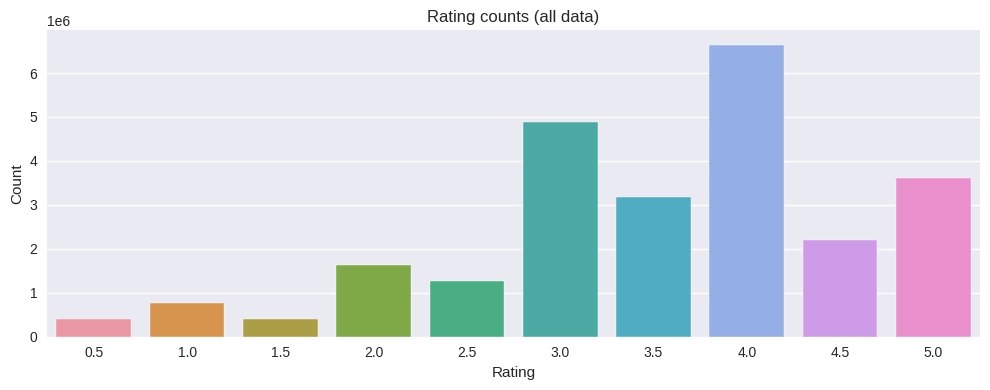

/tmp/ipykernel_119/4095676407.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_time = ratings.dropna(subset=['timestamp']).set_index('timestamp').resample('M').size()


Could not create time-series plot (timestamp parse issue): name 'OUT_FIG_DIR' is not defined


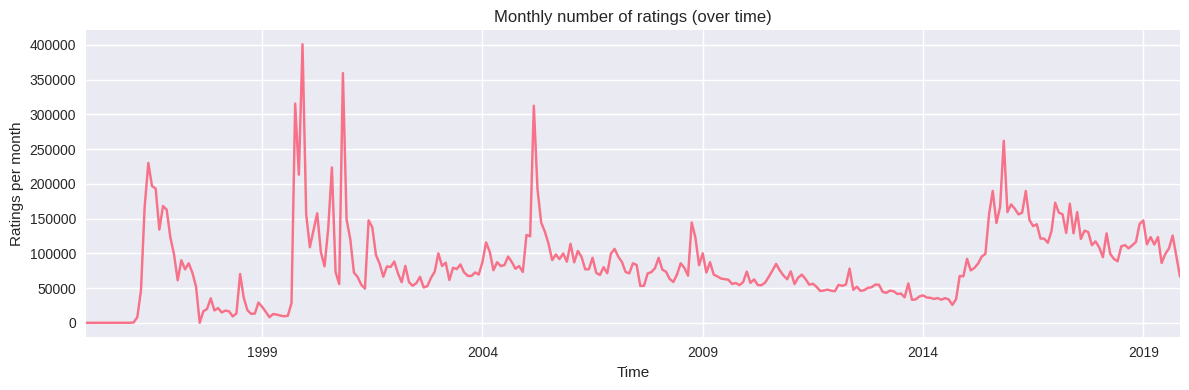

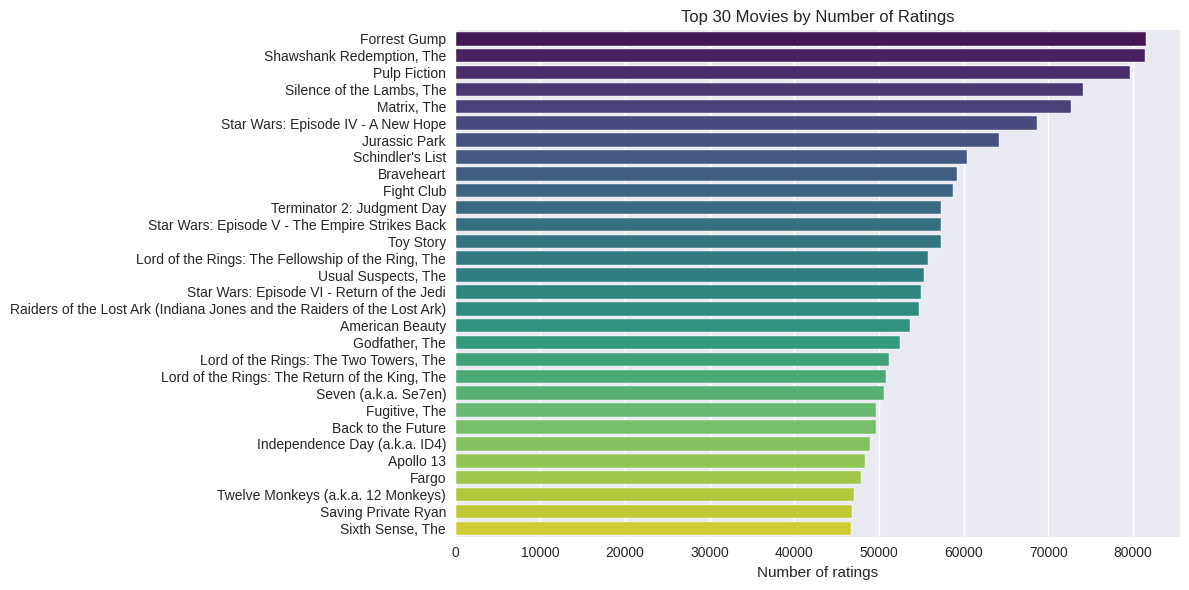

Plotted: top 30 movies by rating count.


NameError: name 'OUT_FIG_DIR' is not defined

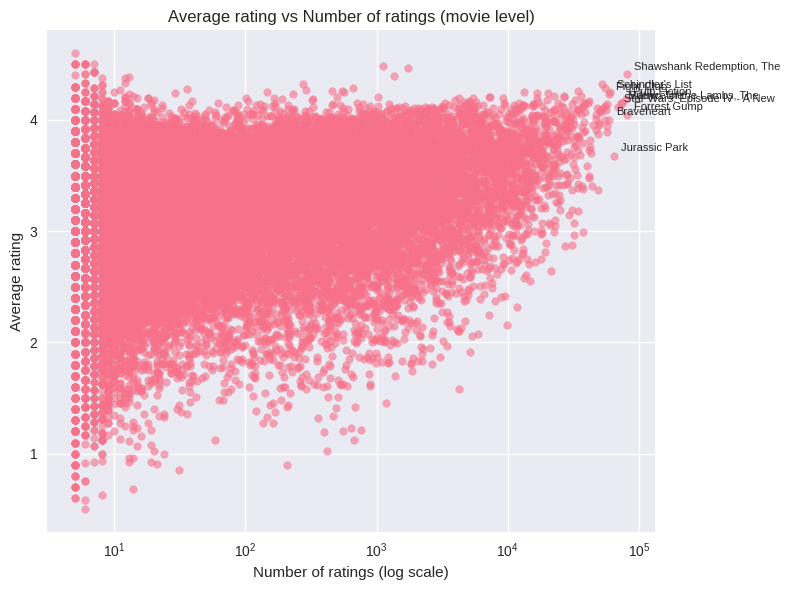

In [12]:
# 1) Rating distribution 
plt.figure(figsize=(10,4))
sns.countplot(x='rating', data=ratings, order=sorted(ratings['rating'].unique()))
plt.title("Rating counts (all data)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# 2) Ratings over time (monthly count) — only if timestamp exists or convertible
if 'timestamp' in ratings.columns:
    try:
        if not np.issubdtype(ratings['timestamp'].dtype, np.datetime64):
            ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s', errors='coerce')
        df_time = ratings.dropna(subset=['timestamp']).set_index('timestamp').resample('M').size()
        if len(df_time) > 0:
            plt.figure(figsize=(12,4))
            df_time.plot()
            plt.title("Monthly number of ratings (over time)")
            plt.ylabel("Ratings per month")
            plt.xlabel("Time")
            plt.tight_layout()
            
            plt.show()
            print("Plotted: monthly rating counts over time.")
    except Exception as e:
        print("Could not create time-series plot (timestamp parse issue):", e)

# 3) Top 30 movies by number of ratings (popularity)
top_n = 30
top_movies = movie_stats.sort_values('movie_count', ascending=False).head(top_n).merge(movies[['movieId','title_clean']], on='movieId', how='left')
plt.figure(figsize=(12,6))
sns.barplot(y='title_clean', x='movie_count', data=top_movies, palette='viridis')
plt.title(f"Top {top_n} Movies by Number of Ratings")
plt.xlabel("Number of ratings")
plt.ylabel("")
plt.tight_layout()
plt.show()

print(f"Plotted: top {top_n} movies by rating count.")

# 4) Average rating vs number of ratings (popularity vs quality)
plt.figure(figsize=(8,6))
plt.scatter(movie_stats['movie_count'], movie_stats['movie_avg'], alpha=0.6, s=30)
plt.xscale('log')
plt.xlabel('Number of ratings (log scale)')
plt.ylabel('Average rating')
plt.title('Average rating vs Number of ratings (movie level)')
# annotate a few top popular movies
popular = movie_stats.sort_values('movie_count', ascending=False).head(10).merge(movies[['movieId','title_clean']], on='movieId', how='left')
for _, row in popular.iterrows():
    plt.annotate(row['title_clean'][:30], (row['movie_count'], row['movie_avg']), xytext=(5,3), textcoords='offset points', fontsize=8)
plt.tight_layout()
plt.show()

print("Plotted: average rating vs number of ratings (log x).")

# 5) User activity: histogram of number of ratings per user (log scale)
plt.figure(figsize=(10,4))
c = user_stats['user_count']
sns.histplot(c, bins=50, log_scale=(False, True))
plt.xlabel('Ratings per user')
plt.title('Distribution of number of ratings per user (y-axis log scale)')
plt.tight_layout()
plt.show()

print("user activity distribution (ratings per user).")

# 6) Movie year distribution (histogram) and average rating by year (if year present)
if 'year' in movies_filt.columns:
    plt.figure(figsize=(12,4))
    years = movies_filt['year'].dropna().astype(int)
    sns.histplot(years, bins=30)
    plt.title("Movie release year distribution (filtered movies)")
    plt.xlabel("Year")
    plt.tight_layout()
    plt.show()

    # avg rating by year (requires merging)
    ms = movie_stats.merge(movies_filt[['movieId','year']], on='movieId', how='left').dropna(subset=['year'])
    if not ms.empty:
        avg_by_year = ms.groupby(ms['year'].astype(int)).agg({'movie_avg':'mean','movie_count':'sum'}).sort_index()
        plt.figure(figsize=(12,4))
        ax = avg_by_year['movie_avg'].plot()
        ax.set_title('Average movie rating by release year (filtered movies)')
        ax.set_xlabel('Year')
        ax.set_ylabel('Average rating')
        plt.tight_layout()
        plt.show()
        print(" movie year distribution and avg rating by year.")


# 9) Correlation heatmap of numeric features (movie_count, movie_avg, movie_year)
numeric_df = movie_stats.merge(movies_filt[['movieId','year']], on='movieId', how='left')
numeric_df = numeric_df[['movie_count','movie_avg','year']].dropna()
if not numeric_df.empty:
    corr = numeric_df.corr()
    plt.figure(figsize=(6,4))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation matrix (movie_count, movie_avg, year)')
    plt.tight_layout()
    plt.show()
    print("correlation heatmap for selected numeric features.")


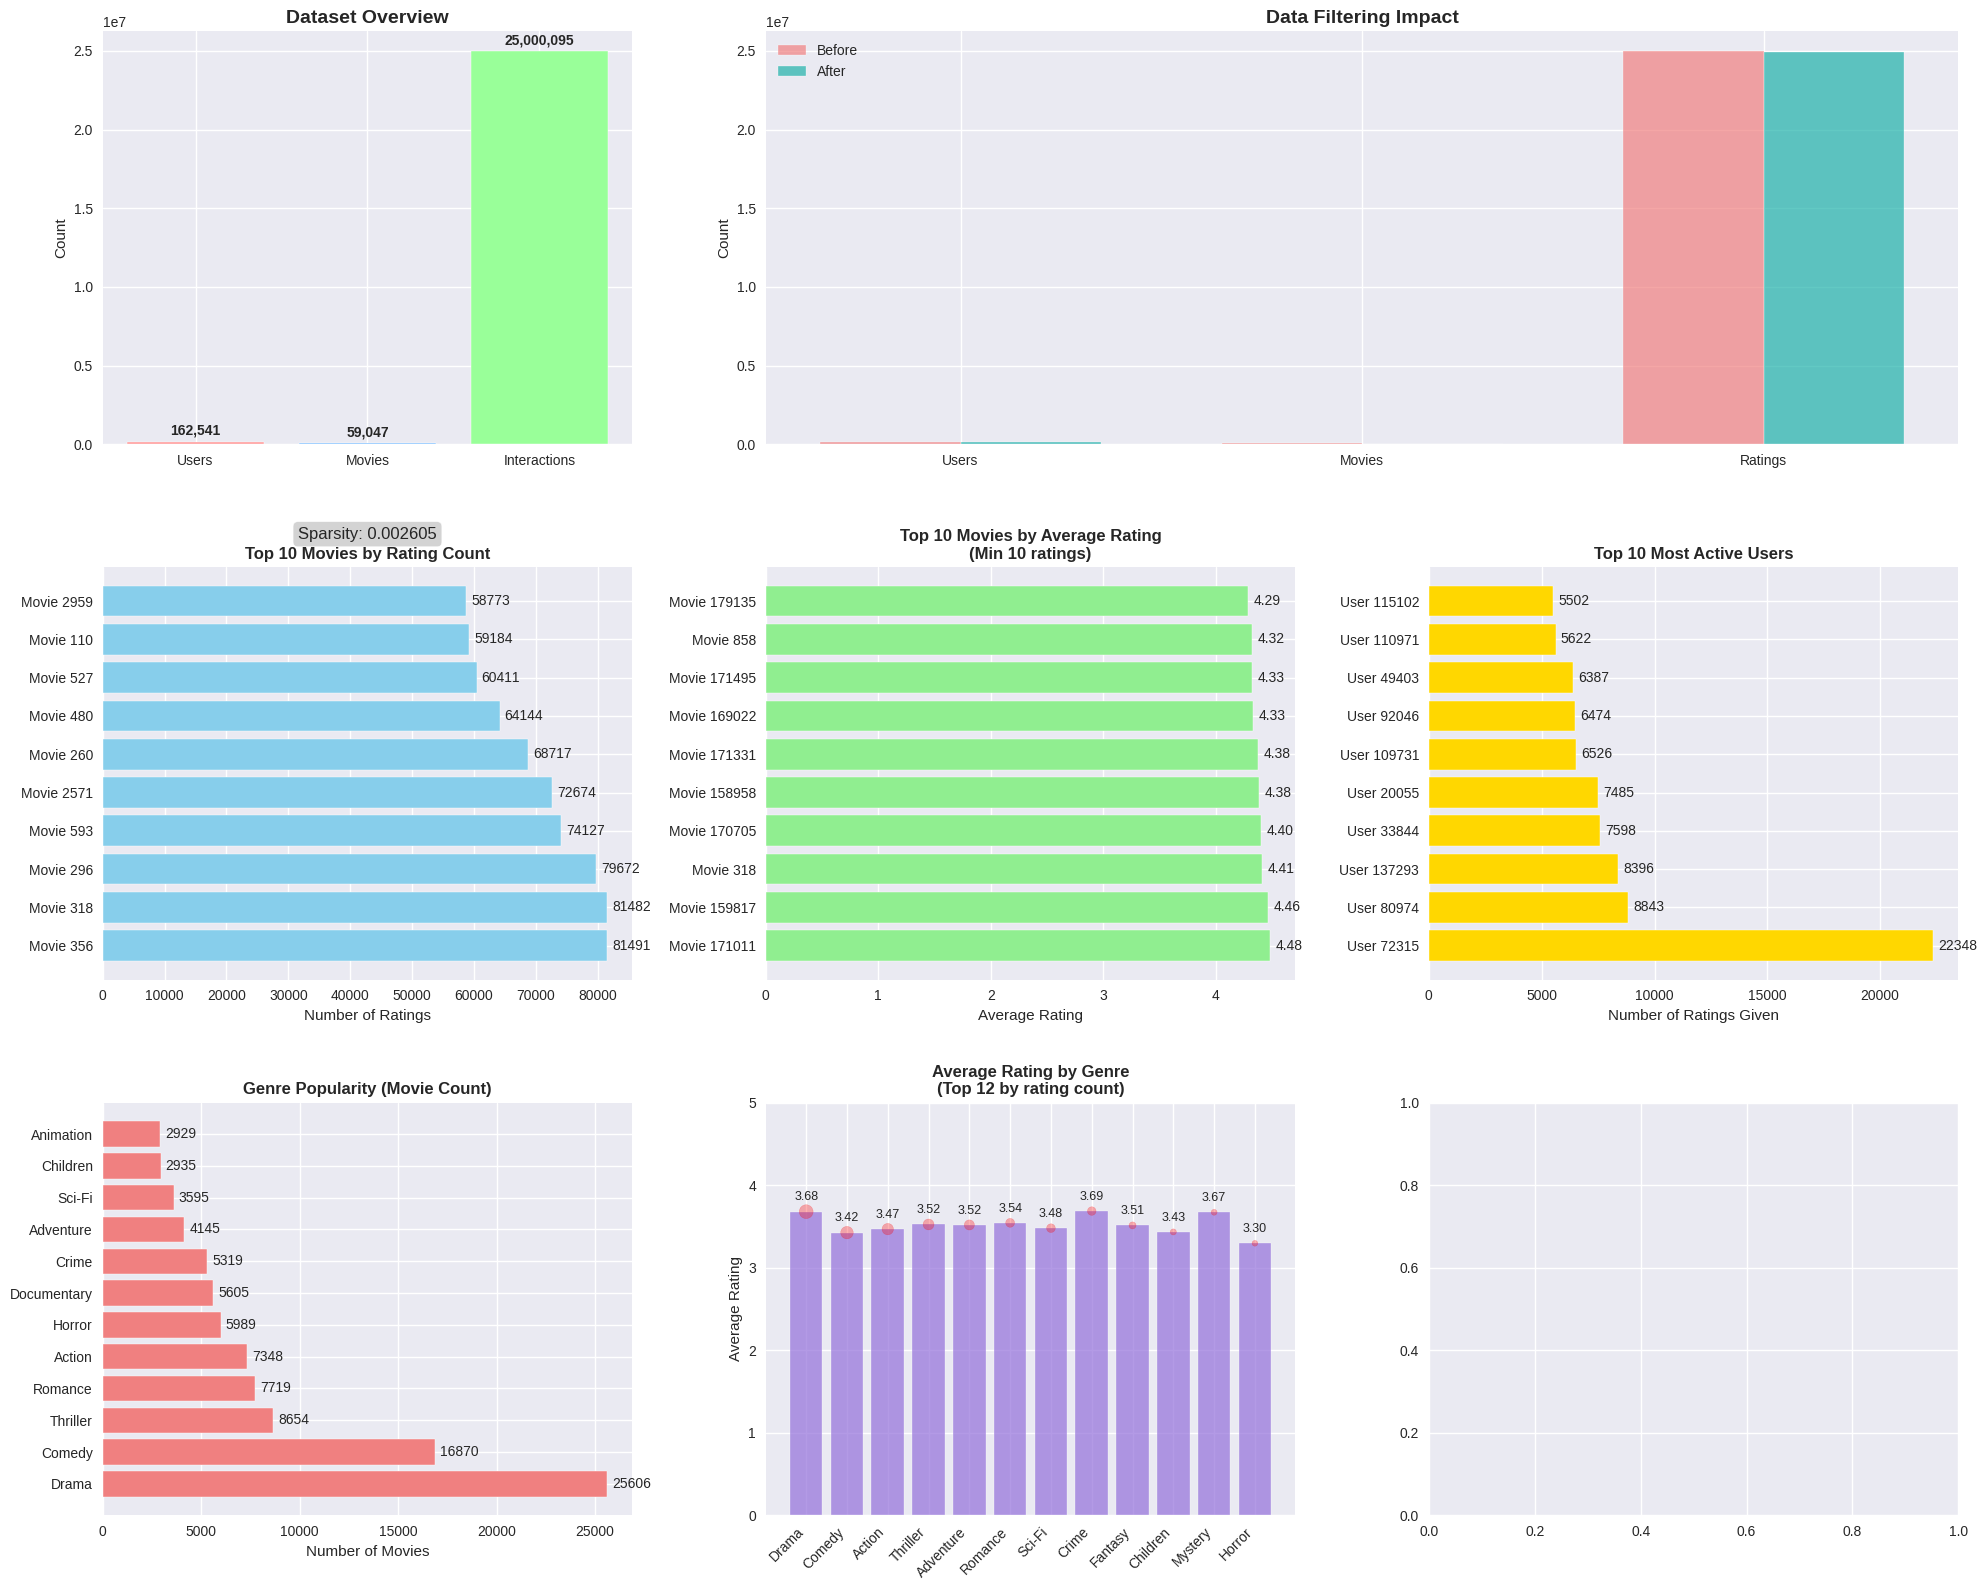

In [10]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

fig = plt.figure(figsize=(20, 16))
n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()
density = len(ratings) / (n_users * n_movies)

# Create summary visualization
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
categories = ['Users', 'Movies', 'Interactions']
values = [n_users, n_movies, len(ratings)]
bars = ax1.bar(categories, values, color=['#ff9999', '#66b3ff', '#99ff99'])
ax1.set_title('Dataset Overview', fontsize=14, fontweight='bold')
ax1.set_ylabel('Count')
for bar, value in zip(bars, values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01, 
             f'{value:,}', ha='center', va='bottom', fontweight='bold')

# Density indicator
ax1.text(0.5, -0.2, f'Sparsity: {density:.6f}', transform=ax1.transAxes, 
         ha='center', va='top', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

# Filter low-activity users and unpopular movies
MIN_USER_RATINGS = 5
MIN_MOVIE_RATINGS = 5
ratings_filt = filter_low_activity(ratings, MIN_USER_RATINGS, MIN_MOVIE_RATINGS)

# Filtering comparison
ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=2)
before_after_data = {
    'Users': [n_users, ratings_filt['userId'].nunique()],
    'Movies': [n_movies, ratings_filt['movieId'].nunique()],
    'Ratings': [len(ratings), len(ratings_filt)]
}
x = np.arange(len(before_after_data))
width = 0.35

for i, (category, values) in enumerate(before_after_data.items()):
    ax2.bar(i - width/2, values[0], width, label='Before' if i == 0 else "", alpha=0.7, color='lightcoral')
    ax2.bar(i + width/2, values[1], width, label='After' if i == 0 else "", alpha=0.7, color='lightseagreen')

ax2.set_title('Data Filtering Impact', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(before_after_data.keys())
ax2.legend()
ax2.set_ylabel('Count')

# 2. Movie Statistics Visualizations
movies_filt = movies[movies['movieId'].isin(ratings_filt['movieId'].unique())].copy()
movie_stats = ratings_filt.groupby('movieId').agg(movie_avg=('rating','mean'), movie_count=('rating','count')).reset_index()

# Top movies by rating count
ax3 = plt.subplot2grid((3, 3), (1, 0))
top_movies_count = movie_stats.nlargest(10, 'movie_count')
bars = ax3.barh(range(len(top_movies_count)), top_movies_count['movie_count'], color='skyblue')
ax3.set_yticks(range(len(top_movies_count)))
ax3.set_yticklabels([f"Movie {id}" for id in top_movies_count['movieId']])
ax3.set_xlabel('Number of Ratings')
ax3.set_title('Top 10 Movies by Rating Count', fontsize=12, fontweight='bold')
for i, bar in enumerate(bars):
    ax3.text(bar.get_width() + max(top_movies_count['movie_count'])*0.01, bar.get_y() + bar.get_height()/2, 
             f'{int(bar.get_width())}', va='center', ha='left', fontsize=10)

# Top movies by average rating (with minimum 10 ratings)
ax4 = plt.subplot2grid((3, 3), (1, 1))
min_ratings = 10
top_movies_avg = movie_stats[movie_stats['movie_count'] >= min_ratings].nlargest(10, 'movie_avg')
bars = ax4.barh(range(len(top_movies_avg)), top_movies_avg['movie_avg'], color='lightgreen')
ax4.set_yticks(range(len(top_movies_avg)))
ax4.set_yticklabels([f"Movie {id}" for id in top_movies_avg['movieId']])
ax4.set_xlabel('Average Rating')
ax4.set_title(f'Top 10 Movies by Average Rating\n(Min {min_ratings} ratings)', fontsize=12, fontweight='bold')
for i, bar in enumerate(bars):
    ax4.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.2f}', va='center', ha='left', fontsize=10)

# User activity distribution
ax5 = plt.subplot2grid((3, 3), (1, 2))
user_stats = ratings_filt.groupby('userId').agg(user_avg=('rating','mean'), user_count=('rating','count')).reset_index()
top_users = user_stats.nlargest(10, 'user_count')
bars = ax5.barh(range(len(top_users)), top_users['user_count'], color='gold')
ax5.set_yticks(range(len(top_users)))
ax5.set_yticklabels([f"User {id}" for id in top_users['userId']])
ax5.set_xlabel('Number of Ratings Given')
ax5.set_title('Top 10 Most Active Users', fontsize=12, fontweight='bold')
for i, bar in enumerate(bars):
    ax5.text(bar.get_width() + max(top_users['user_count'])*0.01, bar.get_y() + bar.get_height()/2, 
             f'{int(bar.get_width())}', va='center', ha='left', fontsize=10)

# 3. Genre Analysis
# Ensure genres_list exists
if 'genres_list' not in movies.columns:
    movies['genres_list'] = movies['genres'].str.split('|')

genre_counter = Counter()
for gl in movies['genres_list']:
    genre_counter.update(gl)
genre_df = pd.DataFrame.from_dict(genre_counter, orient='index', columns=['movie_count']).sort_values('movie_count', ascending=False)

# Genre popularity
ax6 = plt.subplot2grid((3, 3), (2, 0))
top_genres = genre_df.head(12)
bars = ax6.barh(range(len(top_genres)), top_genres['movie_count'], color='lightcoral')
ax6.set_yticks(range(len(top_genres)))
ax6.set_yticklabels(top_genres.index)
ax6.set_xlabel('Number of Movies')
ax6.set_title('Genre Popularity (Movie Count)', fontsize=12, fontweight='bold')
for i, bar in enumerate(bars):
    ax6.text(bar.get_width() + max(top_genres['movie_count'])*0.01, bar.get_y() + bar.get_height()/2, 
             f'{int(bar.get_width())}', va='center', ha='left', fontsize=10)

# Average rating per genre
ratings_genre = ratings_filt.merge(movies_filt[['movieId','genres_list']], on='movieId', how='left').explode('genres_list')
genre_rating = ratings_genre.groupby('genres_list')['rating'].agg(['mean','count']).sort_values('count', ascending=False)

ax7 = plt.subplot2grid((3, 3), (2, 1))
top_genre_ratings = genre_rating.head(12)
x_pos = range(len(top_genre_ratings))
bars = ax7.bar(x_pos, top_genre_ratings['mean'], color='mediumpurple', alpha=0.7)
ax7.set_xticks(x_pos)
ax7.set_xticklabels(top_genre_ratings.index, rotation=45, ha='right')
ax7.set_ylabel('Average Rating')
ax7.set_title('Average Rating by Genre\n(Top 12 by rating count)', fontsize=12, fontweight='bold')
ax7.set_ylim(0, 5)  # Assuming ratings are 0-5 scale

for i, bar in enumerate(bars):
    ax7.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=9)

# Rating count per genre (as scatter size indicator)
sizes = top_genre_ratings['count'] / top_genre_ratings['count'].max() * 100
scatter = ax7.scatter(x_pos, top_genre_ratings['mean'], s=sizes, alpha=0.3, color='red')

# 4. User-Genre Preference Matrix (Heatmap)
ax8 = plt.subplot2grid((3, 3), (2, 2))
user_genre = ratings_genre.groupby(['userId','genres_list'])['rating'].mean().unstack(fill_value=np.nan)

# Take top 10 genres and first 20 users for visualization
top_10_genres = genre_rating.head(10).index
user_genre_sample = user_genre[top_10_genres].iloc[:20]


plt.tight_layout()
plt.show()

#### Part 2.2 : LightFM

=== Ultra-Fast Movie Recommendation System ===

Loading optimized sample of data...
Sample ratings shape: (200000, 4)
Movies shape: (62423, 3)
After filtering: (186516, 4)
Unique users: 1409
Unique movies: 4932
Optimized data preprocessing completed!

📊 Using ultra-fast sample: 186516 ratings
📊 Unique users: 1409
📊 Unique movies: 4932

🚀 ULTRA-FAST TRAINING
Training LightFM model with optimizations...


Epoch: 100%|██████████| 8/8 [00:00<00:00,  9.46it/s]


Model training completed!
⏱️ Training completed in 0.86 seconds


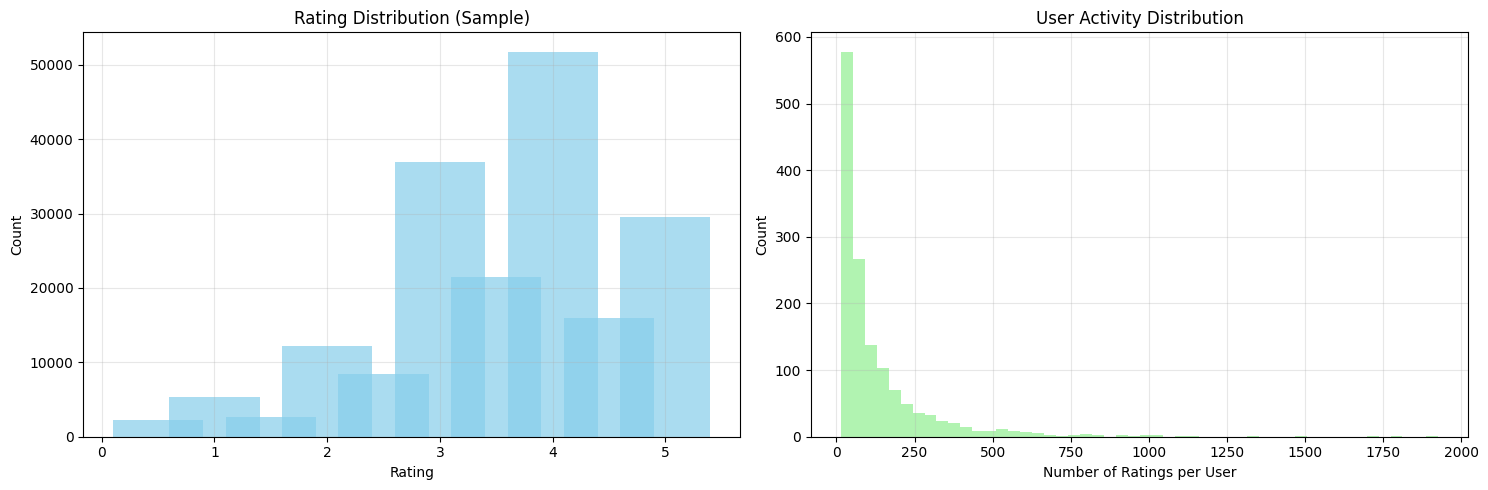


⚡ INSTANT RECOMMENDATIONS

🎯 User 1:
   Recently enjoyed:
     ⭐ 5.0 - Pulp Fiction (1994)
     ⭐ 5.0 - City of God (Cidade de Deus) (2002)
   Recommended for you:
     1. Fight Club (1999) | Score: -0.048
     2. Matrix, The (1999) | Score: -0.183
     3. Godfather, The (1972) | Score: -0.214

🎯 User 2:
   Recently enjoyed:
     ⭐ 5.0 - Matrix, The (1999)
     ⭐ 5.0 - Crocodile Dundee (1986)
   Recommended for you:
     1. Terminator, The (1984) | Score: -1.433
     2. Ghostbusters (a.k.a. Ghost Busters) (1984) | Score: -1.532
     3. E.T. the Extra-Terrestrial (1982) | Score: -1.638

🎯 User 3:
   Recently enjoyed:
     ⭐ 5.0 - Wallace & Gromit: The Wrong Trousers (1993)
     ⭐ 5.0 - Ran (1985)
   Recommended for you:
     1. The Butterfly Effect (2004) | Score: -1.521
     2. Slumdog Millionaire (2008) | Score: -1.644
     3. Deadpool (2016) | Score: -1.669

🔍 SIMILAR MOVIES

Movies similar to: Forrest Gump (1994)
   1. Braveheart (1995) | Similarity: 0.839
   2. Apollo 13 (1995) | 

In [5]:
# Fast Movie Recommender System with LightFM - Fixed Version

import numpy as np
import pandas as pd
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k
from lightfm.cross_validation import random_train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

class FastMovieRecommender:
    def __init__(self, loss='warp', no_components=20, learning_rate=0.05, epochs=10):
        self.model = LightFM(
            loss=loss,
            no_components=no_components,
            learning_rate=learning_rate,
            learning_schedule='adagrad'
        )
        self.dataset = None
        self.interactions = None
        self.epochs = epochs
        self.is_trained = False
        self.loss_history = []
        
    def load_and_preprocess_data(self, ratings_path, movies_path, sample_size=500000, min_ratings=3):
        """
        Optimized data loading with sampling
        """
        print("Loading optimized sample of data...")
        
        # Load sample data
        ratings = pd.read_csv(ratings_path, nrows=sample_size)
        movies = pd.read_csv(movies_path)
        
        print(f"Sample ratings shape: {ratings.shape}")
        print(f"Movies shape: {movies.shape}")
        
        # Filter active users and popular movies
        user_rating_count = ratings['userId'].value_counts()
        valid_users = user_rating_count[user_rating_count >= min_ratings].index
        ratings = ratings[ratings['userId'].isin(valid_users)]
        
        movie_rating_count = ratings['movieId'].value_counts()
        valid_movies = movie_rating_count[movie_rating_count >= 5].index
        ratings = ratings[ratings['movieId'].isin(valid_movies)]
        
        print(f"After filtering: {ratings.shape}")
        print(f"Unique users: {ratings['userId'].nunique()}")
        print(f"Unique movies: {ratings['movieId'].nunique()}")
        
        # Simple approach without problematic features
        self.dataset = Dataset()
        self.dataset.fit(users=ratings['userId'].unique(), items=ratings['movieId'].unique())
        
        # Build interactions
        self.interactions, _ = self.dataset.build_interactions(
            [(row['userId'], row['movieId'], row['rating']) for _, row in ratings.iterrows()]
        )
        
        self.ratings = ratings
        self.movies = movies
        
        print("Optimized data preprocessing completed!")
        return ratings, movies
    
    def train_model(self, test_percentage=0.2, random_state=42):
        if self.interactions is None:
            raise ValueError("Please load data first!")
        
        # Split data
        self.train, self.test = random_train_test_split(
            self.interactions, test_percentage=test_percentage, random_state=random_state
        )
        
        print("Training LightFM model with optimizations...")
        
        # Use fit instead of fit_partial for simplicity and speed
        # LightFM's fit method is optimized internally
        self.model.fit(
            self.train, 
            epochs=self.epochs, 
            num_threads=4,  # Use multiple threads
            verbose=True    # Show progress bar
        )
        
        self.is_trained = True
        print("Model training completed!")
    
    def get_recommendations(self, user_id, n_recommendations=5):
        """
        Get optimized recommendations
        """
        if not self.is_trained:
            raise ValueError("Please train the model first")
        
        try:
            user_internal_id = self.dataset.mapping()[0][user_id]
        except KeyError:
            print(f"User ID {user_id} not found")
            return None
        
        # Get movies user hasn't rated
        user_rated_items = self.interactions.tocsr()[user_internal_id].indices
        all_items = list(self.dataset.mapping()[2].values())
        items_to_predict = list(set(all_items) - set(user_rated_items))
        
        if not items_to_predict:
            print(f"No items to predict for user {user_id}")
            return None
        
        # Predict scores with multiple threads
        scores = self.model.predict(user_internal_id, items_to_predict, num_threads=4)
        
        # Get top recommendations
        top_indices = np.argsort(-scores)[:n_recommendations]
        top_movie_internal_ids = [items_to_predict[i] for i in top_indices]
        
        # Convert back to movie IDs
        reverse_movie_mapping = {v: k for k, v in self.dataset.mapping()[2].items()}
        top_movie_ids = [reverse_movie_mapping[internal_id] for internal_id in top_movie_internal_ids]
        
        # Get movie details
        recommendations = self.movies[self.movies['movieId'].isin(top_movie_ids)].copy()
        movie_to_score = {movie_id: score for movie_id, score in zip(top_movie_ids, scores[top_indices])}
        recommendations['prediction_score'] = recommendations['movieId'].map(movie_to_score)
        
        return recommendations.sort_values('prediction_score', ascending=False)
    
    def get_similar_movies(self, movie_id, n_similar=5):
        """
        Find similar movies quickly
        """
        if not self.is_trained:
            raise ValueError("Please train the model first")
        
        try:
            movie_internal_id = self.dataset.mapping()[2][movie_id]
        except KeyError:
            print(f"Movie ID {movie_id} not found")
            return None
        
        # Get embeddings and calculate similarity
        item_biases, item_embeddings = self.model.get_item_representations()
        movie_embedding = item_embeddings[movie_internal_id].reshape(1, -1)
        similarities = cosine_similarity(movie_embedding, item_embeddings)[0]
        
        # Get similar movies (excluding itself)
        similar_indices = np.argsort(-similarities)[1:n_similar+1]
        reverse_movie_mapping = {v: k for k, v in self.dataset.mapping()[2].items()}
        similar_movie_ids = [reverse_movie_mapping[i] for i in similar_indices]
        
        # Get movie details
        similar_movies = self.movies[self.movies['movieId'].isin(similar_movie_ids)].copy()
        movie_to_similarity = {reverse_movie_mapping[i]: similarities[i] for i in similar_indices}
        similar_movies['similarity_score'] = similar_movies['movieId'].map(movie_to_similarity)
        
        return similar_movies.sort_values('similarity_score', ascending=False)
    
    def plot_data_insights(self):
        """
        Quick visualization of data
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Rating distribution
        rating_counts = self.ratings['rating'].value_counts().sort_index()
        ax1.bar(rating_counts.index, rating_counts.values, alpha=0.7, color='skyblue')
        ax1.set_title('Rating Distribution (Sample)')
        ax1.set_xlabel('Rating')
        ax1.set_ylabel('Count')
        ax1.grid(True, alpha=0.3)
        
        # User activity
        user_activity = self.ratings['userId'].value_counts().values
        ax2.hist(user_activity, bins=50, alpha=0.7, color='lightgreen')
        ax2.set_title('User Activity Distribution')
        ax2.set_xlabel('Number of Ratings per User')
        ax2.set_ylabel('Count')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def get_user_history(self, user_id, n_history=5):
        """Get user's rating history quickly"""
        user_ratings = self.ratings[self.ratings['userId'] == user_id].merge(
            self.movies, on='movieId'
        ).sort_values('rating', ascending=False)
        
        return user_ratings.head(n_history)
    
    def get_popular_movies(self, n_movies=10):
        """Get popular movies quickly"""
        movie_stats = self.ratings.groupby('movieId').agg({
            'rating': ['count', 'mean']
        }).round(2)
        movie_stats.columns = ['rating_count', 'rating_mean']
        
        popular_movies = movie_stats.nlargest(n_movies, ['rating_count', 'rating_mean'])
        
        return popular_movies.merge(self.movies, on='movieId')[
            ['title', 'genres', 'rating_mean', 'rating_count']
        ].sort_values(['rating_count', 'rating_mean'], ascending=False)

# Ultra-fast demo with minimal overhead
def main():
    print("=== Ultra-Fast Movie Recommendation System ===\n")
    
    # Initialize with ultra-fast parameters
    recommender = FastMovieRecommender(
        loss='bpr',        # Faster alternative to warp
        no_components=15,  # Even smaller for speed
        learning_rate=0.05,
        epochs=8          # Fewer epochs
    )
    
    # Load data with ultra-optimized settings
    ratings_path = '/kaggle/input/movie-recommendation-system/ratings.csv'
    movies_path = '/kaggle/input/movie-recommendation-system/movies.csv'
    
    try:
        # Use even smaller sample for maximum speed
        ratings, movies = recommender.load_and_preprocess_data(
            ratings_path, movies_path, 
            sample_size=200000,  # Only 200k ratings
            min_ratings=2        # Lower threshold
        )
        
        print(f"\n📊 Using ultra-fast sample: {len(ratings)} ratings")
        print(f"📊 Unique users: {ratings['userId'].nunique()}")
        print(f"📊 Unique movies: {ratings['movieId'].nunique()}")
        
    except Exception as e:
        print(f"Error loading data: {e}")
        return
    
    # Train model quickly
    print("\n" + "="*50)
    print("🚀 ULTRA-FAST TRAINING")
    print("="*50)
    
    import time
    start_time = time.time()
    
    recommender.train_model(test_percentage=0.2)
    
    training_time = time.time() - start_time
    print(f"⏱️ Training completed in {training_time:.2f} seconds")
    
    # Show data insights
    recommender.plot_data_insights()
    
    # Quick recommendations
    print("\n" + "="*50)
    print("⚡ INSTANT RECOMMENDATIONS")
    print("="*50)
    
    # Get a few sample users
    sample_users = ratings['userId'].unique()[:3]
    
    for user_id in sample_users:
        print(f"\n🎯 User {user_id}:")
        
        # Show user's top rated movies
        user_history = recommender.get_user_history(user_id, n_history=2)
        if len(user_history) > 0:
            print("   Recently enjoyed:")
            for _, movie in user_history.iterrows():
                print(f"     ⭐ {movie['rating']} - {movie['title']}")
        
        # Get fast recommendations
        recommendations = recommender.get_recommendations(user_id, n_recommendations=3)
        if recommendations is not None and len(recommendations) > 0:
            print("   Recommended for you:")
            for idx, (_, movie) in enumerate(recommendations.iterrows(), 1):
                print(f"     {idx}. {movie['title']} | Score: {movie['prediction_score']:.3f}")
    
    # Show similar movies quickly
    print("\n" + "="*50)
    print("🔍 SIMILAR MOVIES")
    print("="*50)
    
    # Find a popular movie
    popular_movie_id = ratings['movieId'].value_counts().index[0]
    movie_title = movies[movies['movieId'] == popular_movie_id]['title'].values[0]
    
    print(f"\nMovies similar to: {movie_title}")
    similar_movies = recommender.get_similar_movies(popular_movie_id, n_similar=3)
    
    if similar_movies is not None and len(similar_movies) > 0:
        for idx, (_, movie) in enumerate(similar_movies.iterrows(), 1):
            print(f"   {idx}. {movie['title']} | Similarity: {movie['similarity_score']:.3f}")
    
    # Show popular movies as fallback
    print("\n" + "="*50)
    print("🏆 POPULAR RIGHT NOW")
    print("="*50)
    
    popular_movies = recommender.get_popular_movies(n_movies=3)
    for idx, (_, movie) in enumerate(popular_movies.iterrows(), 1):
        print(f"   {idx}. {movie['title']} | Avg: {movie['rating_mean']} | Votes: {movie['rating_count']}")

# Run the ultra-fast version
if __name__ == "__main__":
    main()

print("\n" + "="*60)
print("✅ ULTRA-FAST RECOMMENDATION SYSTEM READY!")
print("="*60)